In [2]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [3]:
import pandas as pd
import os

In [4]:
from sklearn.decomposition import PCA
from data_reader import read_banking_data
df, df_codified = read_banking_data()

pca = PCA(n_components=3)
reduced = pca.fit_transform(df_codified.loc[:,df_codified.columns!="y"])
df_reduced = pd.DataFrame(data = reduced, columns = ["x", "y", "z"])
df_reduced["label"] = df.y
df_reduced["pi"] = "pi0"

In [29]:
def pca_experiment(df):
    pca = PCA()
    pca.fit(df)
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_[:3]))
    print(sum(pca.explained_variance_ratio_[:2]))
pca_experiment(df_codified.loc[:,df.columns!="y"])

[6.26788004e-01 3.30833615e-01 4.08471400e-02 1.01374092e-03
 1.92314271e-04 1.20238712e-04 6.96673197e-05 4.96416195e-05
 3.82617908e-05 1.80198272e-05 9.08848239e-06 7.24184225e-06
 4.84543109e-06 2.87288460e-06 1.92717561e-06 1.42287924e-06
 1.31112996e-06 2.47969899e-07 2.17159931e-07 1.81502791e-07]
0.998468759079651
0.9576216190451263


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot_per_label(df):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    yes = df.loc[df.label == "yes"]
    no = df.loc[df.label == "no"]
    ax.scatter3D(yes.x, yes.y, yes.z, alpha=0.5, label = "yes")
    ax.scatter3D(no.x, no.y, no.z, alpha=0.5, label = "no")
    plt.legend()
    plt.show()

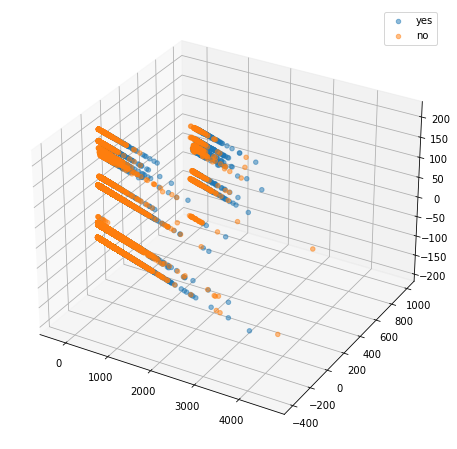

In [32]:
plot_per_label(df_reduced)

In [5]:
yes = df_reduced.loc[df_reduced.label == "yes"]
no = df_reduced.loc[df_reduced.label == "no"]
sample_size = min(yes.shape[0], no.shape[0])
balanced_data =  pd.concat([yes.sample(sample_size), no.sample(sample_size)]).sample(frac=1).reset_index(drop=True)

In [6]:
balanced_data.shape, df_reduced.shape

((9280, 5), (41188, 5))

In [7]:
from sklearn.mixture import GaussianMixture as GM
from sklearn.cluster import KMeans
import numpy as np

def plot_clusters(train, test, n_clusters, clf="gm", return_clusters = False):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    if clf == "gm":
        clf = GM(n_components = n_clusters, random_state = 0)
    else:
        clf = KMeans(n_clusters = n_clusters, random_state = 0)
    clf.fit(train[["x", "y", "z"]])
    pred = clf.predict(test[["x", "y", "z"]])
    cluster_data = []
    for cluster in range(n_clusters):
        cluster_points_indices = list(np.where(pred == cluster)[0])
        cluster_points = test.loc[cluster_points_indices]
        cluster_data.append(cluster_points)
        ax.scatter3D(cluster_points.x, cluster_points.y, cluster_points.z, alpha=0.3, label = str(cluster+1))
    plt.legend()
    plt.show()
    if return_clusters:
        return cluster_data

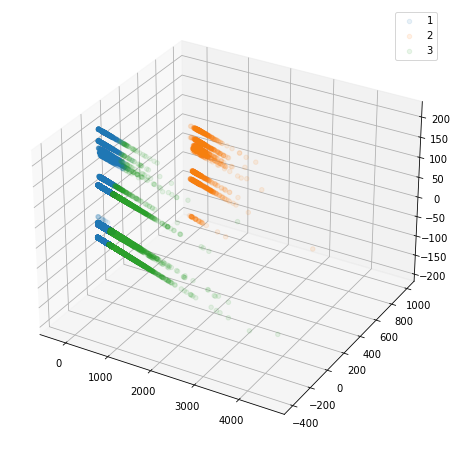

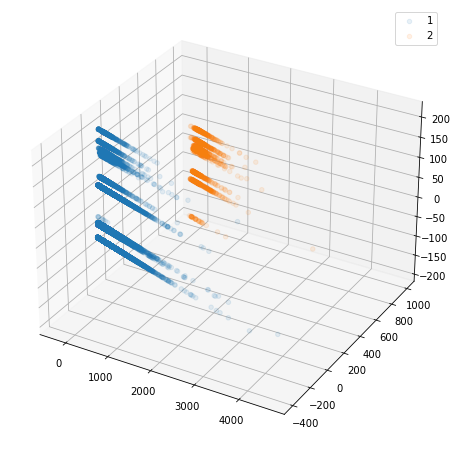

(None, None)

In [125]:
plot_clusters(balanced_data, df_reduced, 3),  plot_clusters(balanced_data,  df_reduced, 2)

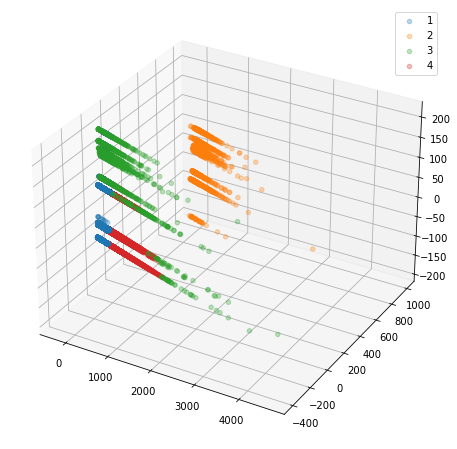

In [10]:
clusters = plot_clusters(balanced_data, df_reduced, 4, return_clusters = True)

In [66]:
## we merge clusters 2 & 4 to create a larger node
merged_clusters = [clusters[0], pd.concat(clusters[1:3], ignore_index=True), clusters[3]]

In [11]:
def create_nodes(df):
    sample_size = 4000    
    if df.shape[0] < sample_size:
        return [df]
    raw_node_data= []
    shuffled_df = df.sample(frac=1)
    no_nodes = int(df.shape[0]/sample_size)
    for i in range(no_nodes):
        node_df = shuffled_df.iloc[i*sample_size:(i+1) * sample_size].copy()
        raw_node_data.append(node_df)
    return raw_node_data

In [67]:
i=1
raw_node_data = []
for cluster in merged_clusters:
    nodes = create_nodes(cluster)
    for node in nodes:
        node.loc[:, "pi"] = "pi"+ str(i)
        node.reset_index(drop=True, inplace=True)
        i+=1
        raw_node_data.append(node)

In [70]:
node_data

[               x          y          z label   pi
 0     -81.938298 -39.829882 -53.867269    no  pi1
 2    -156.996200 -28.092081 -16.675335    no  pi1
 3    -182.921334 -26.116331 -16.509196    no  pi1
 4     -85.939750 -39.551118 -53.848767    no  pi1
 5     -85.926890 -39.542653 -53.761843    no  pi1
 ...          ...        ...        ...   ...  ...
 3995  -55.292306 -35.794211 -17.401324    no  pi1
 3996 -173.950561 -26.775455 -16.580282    no  pi1
 3997 -246.831561 -22.012696 -20.681639    no  pi1
 3998   36.230660 -27.861491  72.779449    no  pi1
 3999 -118.830189 -37.046819 -53.522001    no  pi1
 
 [3601 rows x 5 columns],
                x          y          z label   pi
 0    -180.649452 -32.319491 -53.149490    no  pi2
 1    -225.517875 -28.894752 -52.814205    no  pi2
 2      16.289012 -26.345731  72.950320    no  pi2
 3     -12.143627 -45.178074 -54.305144    no  pi2
 4    -202.588864 -30.660108 -52.950045    no  pi2
 ...          ...        ...        ...   ...  ...
 39

In [69]:
from similar import remove_outliers
node_data, models = remove_outliers(raw_node_data, return_models=True)

In [71]:
directory = "//".join([os.getcwd(), "data", "bank-marketing", "reduced"])
pd.concat(raw_node_data).reset_index(drop=True).to_csv(directory + "//raw_node_data.csv")
pd.concat(node_data).reset_index(drop=True).to_csv(directory + "//node_data.csv")

In [72]:
from node import get_node_data
directory = "//".join([os.getcwd(), "data", "bank-marketing", "reduced", "node_data.csv"])
data = pd.read_csv(directory, header =0, index_col = 0)
node_data = get_node_data(data, experiment =False)

In [27]:
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_nodes, other_nodes, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_nodes, other_nodes, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

In [73]:
from maximum_mean_discrepancy import get_tensor_samples
tensor_sample_size = min([df.shape[0] for df in node_data])
tensor_samples = get_tensor_samples(node_data, sample_size=tensor_sample_size)

In [75]:
import numpy as np
similar_nodes = ["pi1", "pi4", "pi5", "pi6", "pi7", "pi8"]
other_nodes = ["pi" +str(i+1) for i in range(10) if "pi" +str(i+1) not in similar_nodes]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.5, 2, 4), "linear")

LINEAR 

+----------------+---------------+
|     Nodes      |  Similar MMD  |
+----------------+---------------+
| ('pi1', 'pi4') | 8.86474609375 |
| ('pi1', 'pi5') |  6.4501953125 |
| ('pi1', 'pi6') | 5.91943359375 |
| ('pi1', 'pi7') |   4.67578125  |
| ('pi1', 'pi8') | 5.71923828125 |
| ('pi4', 'pi5') | 5.24169921875 |
| ('pi4', 'pi6') |  9.580078125  |
| ('pi4', 'pi7') | 8.35400390625 |
| ('pi4', 'pi8') |  5.7568359375 |
| ('pi5', 'pi6') | 7.15576171875 |
| ('pi5', 'pi7') |  6.1025390625 |
| ('pi5', 'pi8') | 4.80712890625 |
| ('pi6', 'pi7') | 5.55810546875 |
| ('pi6', 'pi8') |  6.8037109375 |
| ('pi7', 'pi8') | 5.49658203125 |
| ('pi3', 'pi1') |  4.7646484375 |
| ('pi3', 'pi5') |  5.9169921875 |
| ('pi3', 'pi6') | 5.32666015625 |
| ('pi3', 'pi7') |   4.65234375  |
| ('pi3', 'pi8') | 5.40087890625 |
+----------------+---------------+
+-----------------+----------------+
|      Nodes      | Dissimilar MMD |
+-----------------+----------------+
|  ('pi2', 'pi1') |  74337.484375  |
|  

In [76]:
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1000, 10000, 5), "rbf")

RBF 

+-----------------+------------------------+
|      Nodes      |      Similar MMD       |
+-----------------+------------------------+
|  ('pi1', 'pi4') | 0.0006637871265411377  |
|  ('pi1', 'pi5') | 0.0007729828357696533  |
|  ('pi1', 'pi6') | 0.0004648864269256592  |
|  ('pi1', 'pi7') | 0.0008085817098617554  |
|  ('pi1', 'pi8') | 0.0004117637872695923  |
|  ('pi4', 'pi5') | 0.0008333921432495117  |
|  ('pi4', 'pi6') | 0.0006364583969116211  |
|  ('pi4', 'pi7') | 0.0007038265466690063  |
|  ('pi4', 'pi8') | 0.0006386786699295044  |
|  ('pi5', 'pi6') | 0.0006059408187866211  |
|  ('pi5', 'pi7') | 0.0008923262357711792  |
|  ('pi5', 'pi8') | 0.0005986839532852173  |
|  ('pi6', 'pi7') |  0.000917479395866394  |
|  ('pi6', 'pi8') | 0.00032438337802886963 |
|  ('pi7', 'pi8') | 0.0008211135864257812  |
|  ('pi3', 'pi6') | 0.0004638582468032837  |
|  ('pi3', 'pi8') | 0.0005930066108703613  |
| ('pi2', 'pi10') | 0.0006618425250053406  |
+-----------------+------------------------+
+---

+-----------------+------------------------+
|      Nodes      |      Similar MMD       |
+-----------------+------------------------+
|  ('pi1', 'pi4') | 0.0006949305534362793  |
|  ('pi1', 'pi5') | 0.0007248520851135254  |
|  ('pi1', 'pi6') | 0.0005143284797668457  |
|  ('pi1', 'pi7') | 0.0004877448081970215  |
|  ('pi1', 'pi8') | 0.0004540681838989258  |
|  ('pi4', 'pi5') | 0.0005038976669311523  |
|  ('pi4', 'pi6') | 0.0007139444351196289  |
|  ('pi4', 'pi7') | 0.0006126165390014648  |
|  ('pi4', 'pi8') | 0.0004680752754211426  |
|  ('pi5', 'pi6') | 0.0006526708602905273  |
|  ('pi5', 'pi7') | 0.0007693767547607422  |
|  ('pi5', 'pi8') | 0.00048297643661499023 |
|  ('pi6', 'pi7') | 0.0007741451263427734  |
|  ('pi6', 'pi8') | 0.0004622340202331543  |
|  ('pi7', 'pi8') | 0.0005665421485900879  |
|  ('pi3', 'pi1') | 0.00043016672134399414 |
|  ('pi3', 'pi6') | 0.0004888772964477539  |
|  ('pi3', 'pi7') | 0.0005614757537841797  |
|  ('pi3', 'pi8') | 0.00048035383224487305 |
| ('pi2', 

In [ ]:
"linear", 2
"rbf", 3250